# Semester 3 Coding Portfolio Topic 6 Formative Part 2/2:
# Agent-Based Modeling and Managing Epidemics 🦠🦠🦠

This notebook covers the following topics:
 - Disease modelling

This notebook is expected to take around 5 hours to complete:
 - 2 hours for the formative part
 - 3 hours of self-study on the topics covered by this notebook

<b>Formative section</b><br>
Simply complete the given functions such that they pass the automated tests. This part is graded Pass/Fail; you must get 100% correct!
You can submit your notebook through Canvas as often as you like. Make sure to start doing so early to insure that your code passes all tests!
You may ask for help from fellow students and TAs on this section, and solutions might be provided later on.

In [1]:
# TODO: Please enter your student number here
# Replace the placeholder with your actual student number
STUDENT_NUMBER = "15281914"  # Example: "12345678"

In this notebook, we’ll return to one of the defining global experiences of our time — the COVID-19 pandemic — to explore how we can use simple models to understand the spread of an epidemic and the impact of public policies.

As we’ve discussed in the lectures, modeling is a powerful tool for thinking through complex social and biological processes.
It allows us to test interventions in a controlled, simulated environment — asking “what if” questions that would be impossible or unethical to test in the real world.

We’ll start with basic epidemic models and gradually increase their complexity.
Along the way, we’ll see how modeling can help us reason about the effects of policy choices — such as distancing, vaccination, or lockdowns — on the course of an outbreak.

By the end, you’ll understand how these models can shed light on real-world decisions and why they remain central to public health and policy planning.

In [2]:
# Imports
# First, install all necessary packages to avoid kernel restarts
import subprocess
import sys

# Install required packages if not already installed
packages = ['numpy', 'matplotlib', 'ipython']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

# Now import the packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

print("All packages installed and imported successfully!")

Installing ipython...
All packages installed and imported successfully!


## 1. Mathematical/Compartmental model: The SIR Model

The **SIR model** is one of the simplest ways to describe how an infectious disease spreads through a population. It is not an ABM, but a mathematical model. It divides people into three groups:

* **S (Susceptible):** individuals who can catch the disease
* **I (Infected):** individuals who currently have the disease and can spread it
* **R (Recovered):** individuals who have recovered (or died) and can no longer spread the disease

The model assumes a fixed population size (N = S + I + R).
At each time step:

* Some susceptible people become infected, depending on how often they meet infected individuals and how contagious the disease is.
* Infected people recover at a certain rate.

The key parameters are:

* **beta (β):** transmission rate (how quickly the disease spreads)
* **gamma (γ):** recovery rate (how quickly infected people recover)
* **R0 = beta / gamma:** the basic reproduction number — the average number of people infected by one sick person in a fully susceptible population.

The code below uses a simple numerical simulation (Euler’s method) to model how S, I, and R change over time and plots the results, including how an intervention (reducing beta) affects the spread of the disease.


In [3]:
# --------------------------------------------------------
# SIMULATION FUNCTION (SIRD) # SIR MODEL + DEATH
# --------------------------------------------------------
def simulate_sird(beta=0.30, gamma=0.10, mu=0.005, N=1_000_000,
                  I0=10, R0_init=0, D0_init=0, days=180, dt=0.1,
                  beta_fn=None, mu_fn=None, use_live_population=True):
    """
    Simulate an SIRD model (Susceptible–Infected–Recovered–Dead)
    with explicit Euler time stepping.

    Parameters
    ----------
    beta : float
        Transmission rate per day.
    gamma : float
        Recovery rate per day (while infected).
    mu : float
        Death rate per day (while infected).
    N : int
        Initial total population (S + I + R + D at t=0).
    I0, R0_init, D0_init : int
        Initial counts of Infected, Recovered, and Dead.
    days : int
        Number of simulated days.
    dt : float
        Time step in days (smaller -> more accurate).
    beta_fn : callable or None
        Optional function beta(t) for time-varying transmission.
    mu_fn : callable or None
        Optional function mu(t) for time-varying mortality.
    use_live_population : bool
        If True, force of infection uses S+I+R (living only).
        If False, uses N (initial total), like classic mass-action SIR.

    Returns
    -------
    t : (T,) array of times (days)
    S, I, R, D : arrays of compartment sizes over time
    """

    # 1) Discretization
    steps = int(days / dt) + 1
    t = np.linspace(0, days, steps)

    # 2) State arrays
    S = np.zeros(steps)
    I = np.zeros(steps)
    R = np.zeros(steps)
    D = np.zeros(steps)

    # 3) Initial conditions
    S[0] = N - I0 - R0_init - D0_init
    I[0] = I0
    R[0] = R0_init
    D[0] = D0_init

    # 4) Time integration
    for k in range(steps - 1):
        # Allow time-varying beta and mu if functions are provided
        b = beta if beta_fn is None else beta_fn(t[k])
        m = mu   if mu_fn   is None else mu_fn(t[k])

        # Choose denominator for the infection term:
        #   live = S + I + R (nobody meets the dead)
        #   or classical = N (initial total)
        if use_live_population:
            N_den = max(S[k] + I[k] + R[k], 1e-12)
        else:
            N_den = max(S[0] + I[0] + R[0] + D[0], 1e-12)

        # --- SIRD ODEs (per-unit-time rates) ---
        # dS/dt = - beta * S * I / N_den
        # dI/dt =   beta * S * I / N_den - gamma * I - mu * I
        # dR/dt =   gamma * I
        # dD/dt =   mu * I
        dS = -b * S[k] * I[k] / N_den
        dI =  b * S[k] * I[k] / N_den - (gamma + m) * I[k]
        dR =  gamma * I[k]
        dD =  m * I[k]

        # Euler updates
        S[k+1] = S[k] + dS * dt
        I[k+1] = I[k] + dI * dt
        R[k+1] = R[k] + dR * dt
        D[k+1] = D[k] + dD * dt

        # Numerical safety: clamp tiny negatives from rounding
        S[k+1] = max(S[k+1], 0.0)
        I[k+1] = max(I[k+1], 0.0)
        R[k+1] = max(R[k+1], 0.0)
        D[k+1] = max(D[k+1], 0.0)

    return t, S, I, R, D


# --------------------------------------------------------
# PLOTTING FUNCTION
# --------------------------------------------------------
def plot_sird(t, S, I, R, D, title="SIRD model dynamics"):
    """
    Plot S, I, R, D over time.
    """
    plt.figure(figsize=(8, 4.8))
    plt.plot(t, S, label="Susceptible", color="tab:blue")
    plt.plot(t, I, label="Infected",    color="tab:red")
    plt.plot(t, R, label="Recovered",   color="tab:green")
    plt.plot(t, D, label="Dead",        color="tab:gray")
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

R0 (SIRD) = beta / (gamma + mu) = 2.86


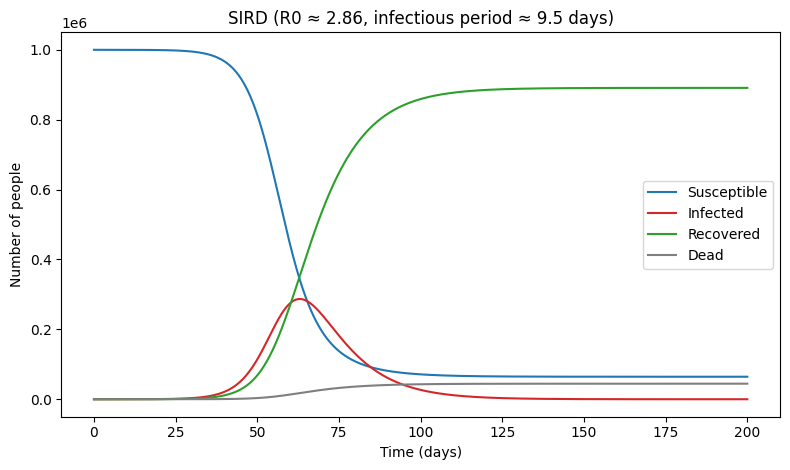

In [4]:
# Parameters (tweak!)
N = 1_000_000
beta = 0.30
gamma = 0.10
mu    = 0.005   # per-day mortality while infected (~0.5% per day)

# R0 in SIRD is beta / (gamma + mu)
R0 = beta / (gamma + mu)
print(f"R0 (SIRD) = beta / (gamma + mu) = {R0:.2f}")

# Run
t, S, I, R, D = simulate_sird(beta=beta, gamma=gamma, mu=mu, N=N, I0=10, days=200, dt=0.1)

# Plot
title = f"SIRD (R0 ≈ {R0:.2f}, infectious period ≈ {1/(gamma+mu):.1f} days)"
plot_sird(t, S, I, R, D, title=title)

### 🧮 Understanding the relationship between β, γ, μ, and R₀

In this extended **SIR** model (often called an **SIRD** model), three key parameters control how an epidemic evolves:

- **β (beta)** – the **transmission rate**: how many susceptible people an infected person infects per day.  
- **γ (gamma)** – the **recovery rate**: the fraction of infected people who recover each day.  
- **μ (mu)** – the **mortality rate**: the fraction of infected people who die each day.

The **basic reproduction number (R₀)** tells us how many people, on average, each infected person will infect in a fully susceptible population.

For this model, the function is:

R0 = β / (γ+μ)

As you may recall, this R0 value was a central discussion point during the COVID pandemic. It stemmed largely from the SIR model. 


## Exercise 1: How does the deadliness of the disease affect how many people die? 

Try to vary the deadliness of the disease and see how it affects how many people die, keeping the other parameters fixed. 

Do a parameter sweep to see how varying the deadliness changes how many people die. 

Explain the result! 


In [5]:
# TODO: Complete the sweep to explore how deadliness (mu) affects total deaths.
def deadliness_to_total_death(
    N=0,
    beta=0.0,  # transmission rate per day
    gamma=0.0,  # recovery rate per day
    I0=0,
    days=0.0,
    dt=0.0,
):
    """
    Sweep mu values and return:
      - deaths_pct: total deaths as % of population
      - final_attack_rate: share ever infected
      - R0_vals: basic reproduction numbers at each mu
      - IFR_vals: infection fatality ratios at each mu
      - mu_vals: grid of mu values explored
    """
    # Create a grid of mu (mortality rate) values to explore
    # We'll test a range from very low (0.001) to high (0.02) mortality rates
    # This covers scenarios from mild to very deadly diseases
    mu_vals = np.linspace(0.001, 0.02, 20)  # 20 evenly spaced values
    
    # Initialize arrays to store results for each mu value
    deaths_pct = np.zeros_like(mu_vals)  # Will store % of population that dies
    final_attack_rate = np.zeros_like(mu_vals)  # Will store % ever infected
    R0_vals = np.zeros_like(mu_vals)  # Will store basic reproduction number
    IFR_vals = np.zeros_like(mu_vals)  # Will store infection fatality ratio
    
    # Loop through each mu value and run a simulation
    for i, mu in enumerate(mu_vals):
        # Run the SIRD simulation with this specific mu value
        # simulate_sird returns: t (time), S (susceptible), I (infected), R (recovered), D (dead)
        t, S, I, R, D = simulate_sird(
            beta=beta,      # Transmission rate (same for all simulations)
            gamma=gamma,    # Recovery rate (same for all simulations)
            mu=mu,          # Mortality rate (varies in each iteration)
            N=N,            # Total population size
            I0=I0,          # Initial number of infected
            days=days,      # Number of days to simulate
            dt=dt           # Time step size
        )
        
        # Calculate metrics from the simulation results:
        
        # 1. Total deaths as percentage of population
        # D[-1] is the final number of dead people (last value in D array)
        # Divide by N and multiply by 100 to get percentage
        deaths_pct[i] = (D[-1] / N) * 100
        
        # 2. Final attack rate: percentage of population that was ever infected
        # Attack rate = (I + R + D) / N, because these are people who got infected
        # I[-1] is final infected, R[-1] is final recovered, D[-1] is final dead
        # All of these were infected at some point
        final_attack_rate[i] = ((I[-1] + R[-1] + D[-1]) / N) * 100
        
        # 3. Basic reproduction number R0
        # R0 = beta / (gamma + mu)
        # This tells us how many people one infected person will infect on average
        # Higher R0 means faster spread
        # Note: as mu increases, R0 decreases because people die faster
        R0_vals[i] = beta / (gamma + mu)
        
        # 4. Infection Fatality Ratio (IFR)
        # IFR = total deaths / total infected
        # This is the probability of dying if you get infected
        # total_infected = I[-1] + R[-1] + D[-1] (all who were ever infected)
        total_infected = I[-1] + R[-1] + D[-1]
        if total_infected > 0:
            # IFR as percentage: (deaths / infected) * 100
            IFR_vals[i] = (D[-1] / total_infected) * 100
        else:
            # If no one got infected, IFR is 0
            IFR_vals[i] = 0.0
    
    return deaths_pct, final_attack_rate, R0_vals, IFR_vals, mu_vals


In [6]:
# ============================================================================
# Test Exercise 1: deadliness_to_total_death function
# ============================================================================
# This test verifies that the function works correctly
#
# ⚠️  IMPORTANT: You MUST run the function definition cell FIRST!
#    Look for the cell that contains: def deadliness_to_total_death(...)
#    It should be the cell BEFORE this one (the cell with the function code)
#    Run that cell first, then come back and run this test cell.
# ============================================================================

# Check if the function is defined - if not, give helpful error message
if 'deadliness_to_total_death' not in globals() or not callable(globals().get('deadliness_to_total_death')):
    print("=" * 70)
    print("❌ ERROR: Function 'deadliness_to_total_death' is not defined!")
    print("=" * 70)
    print("\n📝 SOLUTION:")
    print("   1. Scroll up to find the cell that contains the function definition")
    print("   2. Look for a cell that starts with:")
    print("      '# TODO: Complete the sweep to explore how deadliness (mu) affects total deaths.'")
    print("   3. That cell contains: def deadliness_to_total_death(...)")
    print("   4. Run that cell first (Shift+Enter or click Run)")
    print("   5. Then come back and run this test cell")
    print("\n" + "=" * 70)
    raise NameError(
        "Function 'deadliness_to_total_death' is not defined. "
        "Please run the function definition cell first (the cell above this one)."
    )

print("Testing deadliness_to_total_death function...")

# Test with reasonable parameters
# Wrap in try-except to catch NameError if function isn't defined
try:
    deaths_pct, final_attack_rate, R0_vals, IFR_vals, mu_vals = deadliness_to_total_death(
        N=1_000_000,
        beta=0.30,
        gamma=0.10,
        I0=10,
        days=200,
        dt=0.1
    )
except NameError as e:
    if "'deadliness_to_total_death'" in str(e) or "deadliness_to_total_death" in str(e):
        print("=" * 70)
        print("❌ ERROR: Function 'deadliness_to_total_death' is not defined!")
        print("=" * 70)
        print("\n📝 SOLUTION:")
        print("   1. Scroll up to find the cell that contains the function definition")
        print("   2. Look for a cell that starts with:")
        print("      '# TODO: Complete the sweep to explore how deadliness (mu) affects total deaths.'")
        print("   3. That cell contains: def deadliness_to_total_death(...)")
        print("   4. Run that cell first (Shift+Enter or click Run)")
        print("   5. Then come back and run this test cell")
        print("\n" + "=" * 70)
    raise  # Re-raise the original error

# Verify the function returns arrays of the correct shape
assert len(mu_vals) == 20, f"Expected 20 mu values, got {len(mu_vals)}"
assert len(deaths_pct) == 20, f"Expected 20 death percentages, got {len(deaths_pct)}"
assert len(final_attack_rate) == 20, f"Expected 20 attack rates, got {len(final_attack_rate)}"
assert len(R0_vals) == 20, f"Expected 20 R0 values, got {len(R0_vals)}"
assert len(IFR_vals) == 20, f"Expected 20 IFR values, got {len(IFR_vals)}"

# Verify values are reasonable
assert np.all(deaths_pct >= 0) and np.all(deaths_pct <= 100), "Death percentages should be between 0 and 100"
assert np.all(final_attack_rate >= 0) and np.all(final_attack_rate <= 100), "Attack rates should be between 0 and 100"
assert np.all(R0_vals > 0), "R0 values should be positive"
assert np.all(IFR_vals >= 0) and np.all(IFR_vals <= 100), "IFR values should be between 0 and 100"

# Verify that as mu increases, R0 decreases (because R0 = beta / (gamma + mu))
assert np.all(np.diff(R0_vals) < 0), "R0 should decrease as mu increases"

print("✓ deadliness_to_total_death function works correctly!")
print(f"  Tested {len(mu_vals)} mu values from {mu_vals[0]:.4f} to {mu_vals[-1]:.4f}")
print(f"  Death percentages range from {deaths_pct.min():.2f}% to {deaths_pct.max():.2f}%")
print(f"  R0 values range from {R0_vals.min():.2f} to {R0_vals.max():.2f}")


Testing deadliness_to_total_death function...
✓ deadliness_to_total_death function works correctly!
  Tested 20 mu values from 0.0010 to 0.0200
  Death percentages range from 0.93% to 15.29%
  R0 values range from 2.50 to 2.97


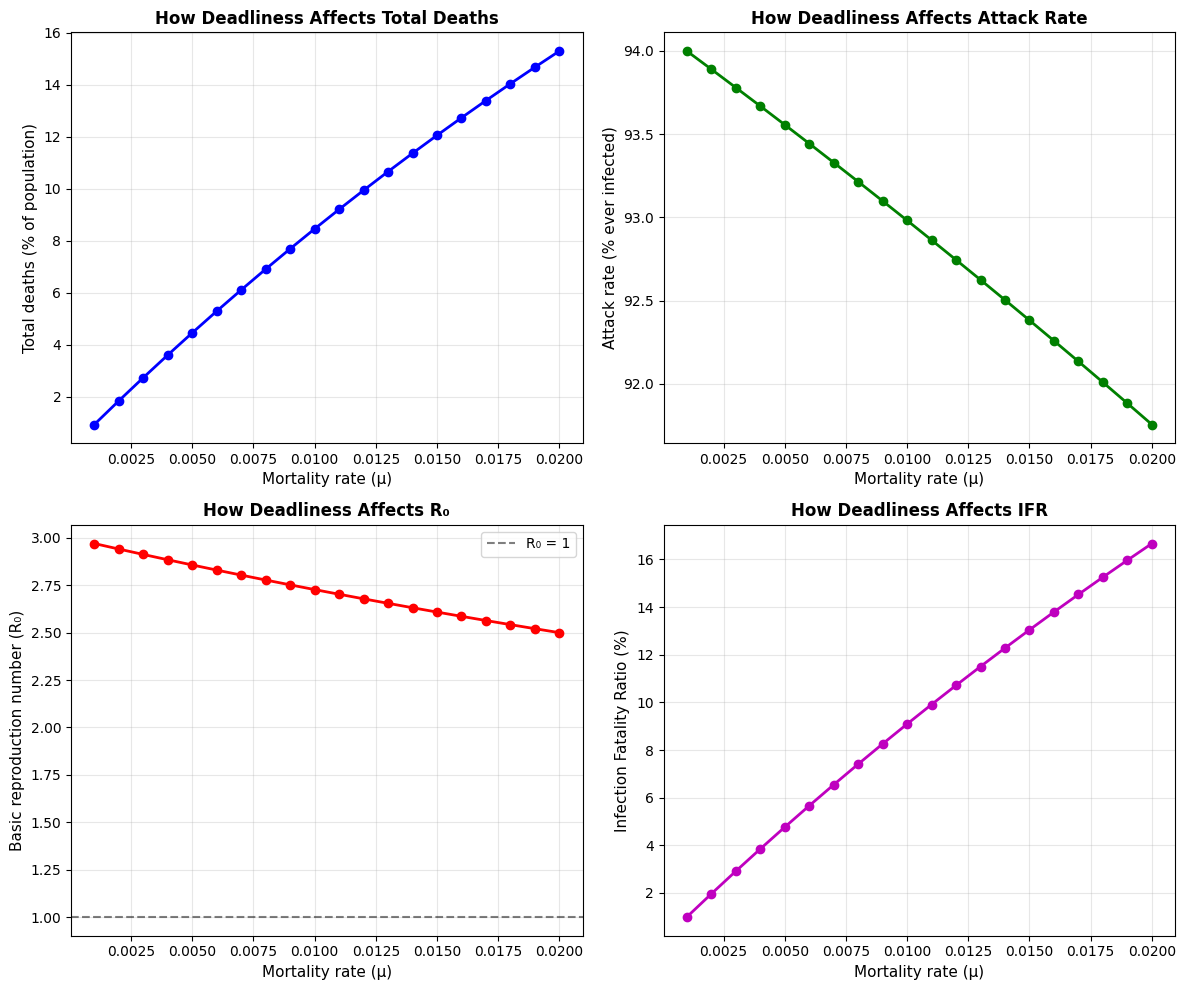

Summary of results:
  As μ increases from 0.0010 to 0.0200:
  - Total deaths increase from 0.93% to 15.29% of population
  - Attack rate changes from 94.00% to 91.76%
  - R₀ decreases from 2.97 to 2.50 (faster deaths = slower spread)
  - IFR increases from 0.99% to 16.67% (deadlier disease)


In [7]:
# Visualize the results from Exercise 1
# This helps understand how deadliness (mu) affects epidemic outcomes

# Run the parameter sweep
deaths_pct, final_attack_rate, R0_vals, IFR_vals, mu_vals = deadliness_to_total_death(
    N=1_000_000,
    beta=0.30,
    gamma=0.10,
    I0=10,
    days=200,
    dt=0.1
)

# Create a figure with multiple subplots to visualize different relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Total deaths as percentage of population vs mu
axes[0, 0].plot(mu_vals, deaths_pct, 'b-o', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Mortality rate (μ)', fontsize=11)
axes[0, 0].set_ylabel('Total deaths (% of population)', fontsize=11)
axes[0, 0].set_title('How Deadliness Affects Total Deaths', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Final attack rate vs mu
axes[0, 1].plot(mu_vals, final_attack_rate, 'g-o', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Mortality rate (μ)', fontsize=11)
axes[0, 1].set_ylabel('Attack rate (% ever infected)', fontsize=11)
axes[0, 1].set_title('How Deadliness Affects Attack Rate', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: R0 vs mu
axes[1, 0].plot(mu_vals, R0_vals, 'r-o', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Mortality rate (μ)', fontsize=11)
axes[1, 0].set_ylabel('Basic reproduction number (R₀)', fontsize=11)
axes[1, 0].set_title('How Deadliness Affects R₀', fontsize=12, fontweight='bold')
axes[1, 0].axhline(y=1, color='k', linestyle='--', alpha=0.5, label='R₀ = 1')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: IFR vs mu
axes[1, 1].plot(mu_vals, IFR_vals, 'm-o', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Mortality rate (μ)', fontsize=11)
axes[1, 1].set_ylabel('Infection Fatality Ratio (%)', fontsize=11)
axes[1, 1].set_title('How Deadliness Affects IFR', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of results:")
print(f"  As μ increases from {mu_vals[0]:.4f} to {mu_vals[-1]:.4f}:")
print(f"  - Total deaths increase from {deaths_pct[0]:.2f}% to {deaths_pct[-1]:.2f}% of population")
print(f"  - Attack rate changes from {final_attack_rate[0]:.2f}% to {final_attack_rate[-1]:.2f}%")
print(f"  - R₀ decreases from {R0_vals[0]:.2f} to {R0_vals[-1]:.2f} (faster deaths = slower spread)")
print(f"  - IFR increases from {IFR_vals[0]:.2f}% to {IFR_vals[-1]:.2f}% (deadlier disease)")


In [ ]:
# TODO: Implement the SIRD model with hospital capacity and overload mortality.

def simulate_sird_capacity(
    beta=0.30,
    gamma=0.10,
    mu_base=0.004,
    mu_over=0.020,
    hospital_need_frac=0.05,
    capacity_frac=0.004,
    N=1_000_000,
    I0=50,
    days=240,
    dt=0.1,
):
    """
    Simulate SIRD with hospital capacity.
    Returns a dictionary with keys: 't', 'S', 'I', 'R', 'D', 'H', 'overload'.
    
    Key concept: When hospitals are overloaded, mortality rate increases!
    - mu_base: normal death rate when hospitals have capacity
    - mu_over: higher death rate when hospitals are overloaded
    - hospital_need_frac: fraction of infected who need hospital care
    - capacity_frac: fraction of population that hospitals can treat
    """
    # Step 1: Set up time discretization
    # Calculate number of time steps based on days and time step size
    steps = int(days / dt) + 1
    t = np.linspace(0, days, steps)  # Array of time points
    
    # Step 2: Initialize state arrays for each compartment
    # These will store the number of people in each state at each time step
    S = np.zeros(steps)  # Susceptible
    I = np.zeros(steps)  # Infected
    R = np.zeros(steps)  # Recovered
    D = np.zeros(steps)  # Dead
    H = np.zeros(steps)  # Hospital load (number needing hospital care)
    
    # Step 3: Set initial conditions
    # At time 0, we have I0 infected, rest are susceptible
    S[0] = N - I0  # Everyone except the initially infected
    I[0] = I0      # Initial infected
    R[0] = 0       # No one recovered yet
    D[0] = 0       # No one dead yet
    H[0] = hospital_need_frac * I[0]  # Initial hospital load
    
    # Calculate absolute hospital capacity (not just fraction)
    capacity = capacity_frac * N
    
    # Track when we're over capacity (for analysis)
    overload = np.zeros(steps, dtype=bool)
    
    # Step 4: Time integration using Euler's method
    # Loop through each time step and update the compartments
    for k in range(steps - 1):
        # Calculate current hospital demand
        # H = hospital_need_frac * I (some fraction of infected need care)
        H[k] = hospital_need_frac * I[k]
        
        # Check if hospitals are overloaded
        # If demand exceeds capacity, we use higher mortality rate
        if H[k] > capacity:
            # Hospitals are overloaded - use higher death rate
            mu_current = mu_over
            overload[k] = True
        else:
            # Hospitals have capacity - use normal death rate
            mu_current = mu_base
            overload[k] = False
        
        # Step 5: Calculate the derivatives (rates of change) for each compartment
        # These come from the SIRD differential equations
        
        # For the denominator in infection term, use living population
        # (dead people don't interact)
        N_den = max(S[k] + I[k] + R[k], 1e-12)  # Avoid division by zero
        
        # dS/dt: Susceptible decrease when they get infected
        # Rate = -beta * S * I / N_den
        # Negative because S decreases
        dS = -beta * S[k] * I[k] / N_den
        
        # dI/dt: Infected increase from new infections, decrease from recovery and death
        # Rate = beta * S * I / N_den - gamma * I - mu * I
        # First term: new infections (positive)
        # Second term: recoveries (negative)
        # Third term: deaths (negative)
        dI = beta * S[k] * I[k] / N_den - (gamma + mu_current) * I[k]
        
        # dR/dt: Recovered increase when infected people recover
        # Rate = gamma * I
        dR = gamma * I[k]
        
        # dD/dt: Dead increase when infected people die
        # Rate = mu * I (using current mu, which depends on hospital capacity)
        dD = mu_current * I[k]
        
        # Step 6: Update compartments using Euler's method
        # New value = old value + rate of change * time step
        S[k+1] = S[k] + dS * dt
        I[k+1] = I[k] + dI * dt
        R[k+1] = R[k] + dR * dt
        D[k+1] = D[k] + dD * dt
        
        # Step 7: Numerical safety - ensure no negative values
        # Sometimes rounding errors can make values slightly negative
        S[k+1] = max(S[k+1], 0.0)
        I[k+1] = max(I[k+1], 0.0)
        R[k+1] = max(R[k+1], 0.0)
        D[k+1] = max(D[k+1], 0.0)
    
    # Calculate final hospital load
    H[-1] = hospital_need_frac * I[-1]
    
    # Return results as a dictionary for easy access
    return {
        't': t,           # Time array
        'S': S,           # Susceptible over time
        'I': I,           # Infected over time
        'R': R,           # Recovered over time
        'D': D,           # Dead over time
        'H': H,           # Hospital load over time
        'capacity': capacity,  # Hospital capacity (constant)
        'overload': overload   # Boolean array: True when over capacity
    }


In [8]:
# This cell was moved - the function definition is now in cell 9 (right after Exercise 1)



## 🏥 Exercise 2: Policy response 1 - Flatten the curve? 

In this exercise, we will explore the idea of “flattening the curve.”

As you may recall, the core idea is that hospitals have limited capacity — only a certain fraction of the population can receive treatment at the same time.
If the number of severely ill patients exceeds that capacity, not everyone can get the care they need, and the mortality rate increases for those left untreated.

In our model:
- A fixed share of infected individuals (for example, 5%) require hospital care.
- The health system can only care for a given maximum number of patients (capacity).
- When hospital demand exceeds that limit, patients outside the system face a higher death rate.
- By lowering R₀ (for instance, through distancing, lockdowns, or mask use), we slow the spread of infections.
- This can keep the number of hospitalized cases below the system’s capacity, preventing overload and ultimately saving lives — even if the total number of infections stays similar.

We will:
- Extend the SIRD model to include hospital capacity and overflow deaths.

Simulate two scenarios:
- Baseline: No intervention (high R₀)
- Policy: R₀ reduced by 30% 

**Key question: How many fewer people die when R₀ is reduced by 30%?**

The goal is to understand why strength of interventions matter and how reducing transmission can save lives not only by preventing infections, but also by avoiding the collapse of the healthcare system.

In [ ]:
# ============================================================================
# Test Exercise 2: simulate_sird_capacity function
# ============================================================================
# This test verifies that the function works correctly
#
# ⚠️  IMPORTANT: You MUST run the function definition cell FIRST!
#    The function definition should be in a cell BEFORE this one.
#    Look for a cell that contains: def simulate_sird_capacity(...)
#    It should start with: "# TODO: Implement the SIRD model with hospital capacity..."
#    Run that cell first, then come back and run this test cell.
# ============================================================================

# Check if the function is defined - if not, give helpful error message
if 'simulate_sird_capacity' not in globals() or not callable(globals().get('simulate_sird_capacity')):
    print("=" * 70)
    print("❌ ERROR: Function 'simulate_sird_capacity' is not defined!")
    print("=" * 70)
    print("\n📝 SOLUTION:")
    print("   1. Scroll up to find the cell that contains the function definition")
    print("   2. Look for a cell that starts with:")
    print("      '# TODO: Implement the SIRD model with hospital capacity and overload mortality.'")
    print("   3. That cell contains: def simulate_sird_capacity(...)")
    print("   4. Run that cell first (Shift+Enter or click Run)")
    print("   5. Then come back and run this test cell")
    print("\n" + "=" * 70)
    raise NameError(
        "Function 'simulate_sird_capacity' is not defined. "
        "Please run the function definition cell first (look for the cell with def simulate_sird_capacity)."
    )

print("Testing simulate_sird_capacity function...")

# Test with reasonable parameters
# Wrap in try-except to catch NameError if function isn't defined
try:
    res = simulate_sird_capacity(
        beta=0.30,
        gamma=0.10,
        mu_base=0.004,
        mu_over=0.020,
        hospital_need_frac=0.05,
        capacity_frac=0.004,
        N=1_000_000,
        I0=50,
        days=240,
        dt=0.1
    )
except NameError as e:
    if "'simulate_sird_capacity'" in str(e) or "simulate_sird_capacity" in str(e):
        print("=" * 70)
        print("❌ ERROR: Function 'simulate_sird_capacity' is not defined!")
        print("=" * 70)
        print("\n📝 SOLUTION:")
        print("   1. Scroll up to find the cell that contains the function definition")
        print("   2. Look for a cell that starts with:")
        print("      '# TODO: Implement the SIRD model with hospital capacity and overload mortality.'")
        print("   3. That cell contains: def simulate_sird_capacity(...)")
        print("   4. Run that cell first (Shift+Enter or click Run)")
        print("   5. Then come back and run this test cell")
        print("\n" + "=" * 70)
    raise  # Re-raise the original error

# Verify the function returns a dictionary with all required keys
required_keys = ['t', 'S', 'I', 'R', 'D', 'H', 'capacity', 'overload']
for key in required_keys:
    assert key in res, f"Missing key '{key}' in result dictionary"

# Verify arrays have the correct shape
steps = int(240 / 0.1) + 1
assert len(res['t']) == steps, f"Expected {steps} time steps, got {len(res['t'])}"
assert len(res['S']) == steps, f"Expected {steps} S values, got {len(res['S'])}"
assert len(res['I']) == steps, f"Expected {steps} I values, got {len(res['I'])}"
assert len(res['R']) == steps, f"Expected {steps} R values, got {len(res['R'])}"
assert len(res['D']) == steps, f"Expected {steps} D values, got {len(res['D'])}"
assert len(res['H']) == steps, f"Expected {steps} H values, got {len(res['H'])}"
assert len(res['overload']) == steps, f"Expected {steps} overload values, got {len(res['overload'])}"

# Verify initial conditions
assert res['S'][0] == 1_000_000 - 50, "Initial susceptible should be N - I0"
assert res['I'][0] == 50, "Initial infected should be I0"
assert res['R'][0] == 0, "Initial recovered should be 0"
assert res['D'][0] == 0, "Initial dead should be 0"

# Verify hospital capacity
expected_capacity = 0.004 * 1_000_000
assert res['capacity'] == expected_capacity, f"Capacity should be {expected_capacity}, got {res['capacity']}"

# Verify values are non-negative
assert np.all(res['S'] >= 0), "S should be non-negative"
assert np.all(res['I'] >= 0), "I should be non-negative"
assert np.all(res['R'] >= 0), "R should be non-negative"
assert np.all(res['D'] >= 0), "D should be non-negative"
assert np.all(res['H'] >= 0), "H should be non-negative"

# Verify hospital load is calculated correctly (H = hospital_need_frac * I)
assert np.allclose(res['H'], 0.05 * res['I'], rtol=1e-5), "Hospital load should equal hospital_need_frac * I"

print("✓ simulate_sird_capacity function works correctly!")
print(f"  Simulated {steps} time steps over {240} days")
print(f"  Hospital capacity: {res['capacity']:,.0f}")
print(f"  Peak hospital load: {res['H'].max():,.0f}")
print(f"  Days over capacity: {np.sum(res['overload']) * 0.1:.1f}")
print(f"  Final deaths: {res['D'][-1]:,.0f}")


Testing simulate_sird_capacity function...


NameError: name 'simulate_sird_capacity' is not defined

In [ ]:
# Visualize Exercise 2: Compare baseline vs intervention (30% reduction in R0)
# This demonstrates the "flatten the curve" concept

print("Comparing baseline vs intervention scenario...")

# Baseline scenario: high R0 (no intervention)
res_baseline = simulate_sird_capacity(
    beta=0.30,  # High transmission rate
    gamma=0.10,
    mu_base=0.004,
    mu_over=0.020,
    hospital_need_frac=0.05,
    capacity_frac=0.004,
    N=1_000_000,
    I0=50,
    days=240,
    dt=0.1
)

# Intervention scenario: 30% reduction in R0 (reduce beta by 30%)
res_intervention = simulate_sird_capacity(
    beta=0.30 * 0.7,  # 30% reduction in transmission rate
    gamma=0.10,
    mu_base=0.004,
    mu_over=0.020,
    hospital_need_frac=0.05,
    capacity_frac=0.004,
    N=1_000_000,
    I0=50,
    days=240,
    dt=0.1
)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: SIRD compartments over time - Baseline
axes[0, 0].plot(res_baseline['t'], res_baseline['S'], label='S', color='tab:blue')
axes[0, 0].plot(res_baseline['t'], res_baseline['I'], label='I', color='tab:red')
axes[0, 0].plot(res_baseline['t'], res_baseline['R'], label='R', color='tab:green')
axes[0, 0].plot(res_baseline['t'], res_baseline['D'], label='D', color='tab:gray')
axes[0, 0].set_xlabel('Time (days)')
axes[0, 0].set_ylabel('Number of people')
axes[0, 0].set_title('Baseline (High R₀)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: SIRD compartments over time - Intervention
axes[0, 1].plot(res_intervention['t'], res_intervention['S'], label='S', color='tab:blue')
axes[0, 1].plot(res_intervention['t'], res_intervention['I'], label='I', color='tab:red')
axes[0, 1].plot(res_intervention['t'], res_intervention['R'], label='R', color='tab:green')
axes[0, 1].plot(res_intervention['t'], res_intervention['D'], label='D', color='tab:gray')
axes[0, 1].set_xlabel('Time (days)')
axes[0, 1].set_ylabel('Number of people')
axes[0, 1].set_title('Intervention (30% R₀ reduction)', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Hospital load comparison
axes[1, 0].plot(res_baseline['t'], res_baseline['H'], label='Baseline', color='tab:red', linewidth=2)
axes[1, 0].plot(res_intervention['t'], res_intervention['H'], label='Intervention', color='tab:green', linewidth=2)
axes[1, 0].axhline(y=res_baseline['capacity'], color='k', linestyle='--', linewidth=2, label='Capacity')
axes[1, 0].set_xlabel('Time (days)')
axes[1, 0].set_ylabel('Hospital load')
axes[1, 0].set_title('Hospital Load: Baseline vs Intervention', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cumulative deaths comparison
axes[1, 1].plot(res_baseline['t'], res_baseline['D'], label='Baseline', color='tab:red', linewidth=2)
axes[1, 1].plot(res_intervention['t'], res_intervention['D'], label='Intervention', color='tab:green', linewidth=2)
axes[1, 1].set_xlabel('Time (days)')
axes[1, 1].set_ylabel('Cumulative deaths')
axes[1, 1].set_title('Cumulative Deaths: Baseline vs Intervention', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)
print(f"Baseline scenario:")
print(f"  Final deaths: {res_baseline['D'][-1]:,.0f} ({res_baseline['D'][-1]/1_000_000*100:.2f}% of population)")
print(f"  Peak infected: {res_baseline['I'].max():,.0f}")
print(f"  Peak hospital load: {res_baseline['H'].max():,.0f}")
print(f"  Days over capacity: {np.sum(res_baseline['overload']) * 0.1:.1f} days")
print(f"\nIntervention scenario (30% R₀ reduction):")
print(f"  Final deaths: {res_intervention['D'][-1]:,.0f} ({res_intervention['D'][-1]/1_000_000*100:.2f}% of population)")
print(f"  Peak infected: {res_intervention['I'].max():,.0f}")
print(f"  Peak hospital load: {res_intervention['H'].max():,.0f}")
print(f"  Days over capacity: {np.sum(res_intervention['overload']) * 0.1:.1f} days")
print(f"\nLives saved by intervention: {res_baseline['D'][-1] - res_intervention['D'][-1]:,.0f} people")
print(f"  ({((res_baseline['D'][-1] - res_intervention['D'][-1]) / res_baseline['D'][-1] * 100):.1f}% reduction)")
print("="*60)


In [ ]:

# TODO: Implement the SIRD model with hospital capacity and overload mortality.

def simulate_sird_capacity(
    beta=0.30,
    gamma=0.10,
    mu_base=0.004,
    mu_over=0.020,
    hospital_need_frac=0.05,
    capacity_frac=0.004,
    N=1_000_000,
    I0=50,
    days=240,
    dt=0.1,
):
    """
    Simulate SIRD with hospital capacity.
    Returns a dictionary with keys: 't', 'S', 'I', 'R', 'D', 'H', 'overload'.
    
    Key concept: When hospitals are overloaded, mortality rate increases!
    - mu_base: normal death rate when hospitals have capacity
    - mu_over: higher death rate when hospitals are overloaded
    - hospital_need_frac: fraction of infected who need hospital care
    - capacity_frac: fraction of population that hospitals can treat
    """
    # Step 1: Set up time discretization
    # Calculate number of time steps based on days and time step size
    steps = int(days / dt) + 1
    t = np.linspace(0, days, steps)  # Array of time points
    
    # Step 2: Initialize state arrays for each compartment
    # These will store the number of people in each state at each time step
    S = np.zeros(steps)  # Susceptible
    I = np.zeros(steps)  # Infected
    R = np.zeros(steps)  # Recovered
    D = np.zeros(steps)  # Dead
    H = np.zeros(steps)  # Hospital load (number needing hospital care)
    
    # Step 3: Set initial conditions
    # At time 0, we have I0 infected, rest are susceptible
    S[0] = N - I0  # Everyone except the initially infected
    I[0] = I0      # Initial infected
    R[0] = 0       # No one recovered yet
    D[0] = 0       # No one dead yet
    H[0] = hospital_need_frac * I[0]  # Initial hospital load
    
    # Calculate absolute hospital capacity (not just fraction)
    capacity = capacity_frac * N
    
    # Track when we're over capacity (for analysis)
    overload = np.zeros(steps, dtype=bool)
    
    # Step 4: Time integration using Euler's method
    # Loop through each time step and update the compartments
    for k in range(steps - 1):
        # Calculate current hospital demand
        # H = hospital_need_frac * I (some fraction of infected need care)
        H[k] = hospital_need_frac * I[k]
        
        # Check if hospitals are overloaded
        # If demand exceeds capacity, we use higher mortality rate
        if H[k] > capacity:
            # Hospitals are overloaded - use higher death rate
            mu_current = mu_over
            overload[k] = True
        else:
            # Hospitals have capacity - use normal death rate
            mu_current = mu_base
            overload[k] = False
        
        # Step 5: Calculate the derivatives (rates of change) for each compartment
        # These come from the SIRD differential equations
        
        # For the denominator in infection term, use living population
        # (dead people don't interact)
        N_den = max(S[k] + I[k] + R[k], 1e-12)  # Avoid division by zero
        
        # dS/dt: Susceptible decrease when they get infected
        # Rate = -beta * S * I / N_den
        # Negative because S decreases
        dS = -beta * S[k] * I[k] / N_den
        
        # dI/dt: Infected increase from new infections, decrease from recovery and death
        # Rate = beta * S * I / N_den - gamma * I - mu * I
        # First term: new infections (positive)
        # Second term: recoveries (negative)
        # Third term: deaths (negative)
        dI = beta * S[k] * I[k] / N_den - (gamma + mu_current) * I[k]
        
        # dR/dt: Recovered increase when infected people recover
        # Rate = gamma * I
        dR = gamma * I[k]
        
        # dD/dt: Dead increase when infected people die
        # Rate = mu * I (using current mu, which depends on hospital capacity)
        dD = mu_current * I[k]
        
        # Step 6: Update compartments using Euler's method
        # New value = old value + rate of change * time step
        S[k+1] = S[k] + dS * dt
        I[k+1] = I[k] + dI * dt
        R[k+1] = R[k] + dR * dt
        D[k+1] = D[k] + dD * dt
        
        # Step 7: Numerical safety - ensure no negative values
        # Sometimes rounding errors can make values slightly negative
        S[k+1] = max(S[k+1], 0.0)
        I[k+1] = max(I[k+1], 0.0)
        R[k+1] = max(R[k+1], 0.0)
        D[k+1] = max(D[k+1], 0.0)
    
    # Calculate final hospital load
    H[-1] = hospital_need_frac * I[-1]
    
    # Return results as a dictionary for easy access
    return {
        't': t,           # Time array
        'S': S,           # Susceptible over time
        'I': I,           # Infected over time
        'R': R,           # Recovered over time
        'D': D,           # Dead over time
        'H': H,           # Hospital load over time
        'capacity': capacity,  # Hospital capacity (constant)
        'overload': overload   # Boolean array: True when over capacity
    }




**Visualization helpers (provided)**  
These functions plot the epidemic with capacity and summarize outcomes so you can inspect your results quickly after implementing simulate_sird_capacity.

In [ ]:

def plot_epidemic_with_capacity(res, title="SIRD with capacity"):
    t, S, I, R, D = res["t"], res["S"], res["I"], res["R"], res["D"]
    H, C = res["H"], res.get("capacity", None)

    plt.figure(figsize=(9, 4.6))
    plt.plot(t, S, label="S")
    plt.plot(t, I, label="I")
    plt.plot(t, R, label="R")
    plt.plot(t, D, label="D")
    plt.title(title)
    plt.xlabel("Day")
    plt.ylabel("People")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 4.2))
    plt.plot(t, H, label="Hospital load (h * I)")
    if C is not None:
        plt.axhline(C, ls="--", label="Capacity")
    plt.title("Hospital load vs capacity")
    plt.xlabel("Day")
    plt.ylabel("Patients in care")
    plt.legend()
    plt.tight_layout()
    plt.show()


def summarize_capacity_outcomes(res):
    t, I, D, H = res["t"], res["I"], res["D"], res["H"]
    C = res.get("capacity", None)
    total_deaths = D[-1]
    peak_I = I.max()
    peak_day = t[I.argmax()]
    peak_H = H.max()
    days_over = np.sum(H > C) * (t[1] - t[0]) if C is not None else 0.0
    print(f"Total deaths: {total_deaths:,.0f}")
    print(f"Peak infected: {peak_I:,.0f} on day {peak_day:.1f}")
    print(f"Peak hospital load: {peak_H:,.0f}")
    if C is not None:
        print(f"Capacity: {C:,.0f}; approx days over capacity: {days_over:.1f}")

## Policy Response 2: "Focused Protection" 

Focused Protection was a famous and hotly debated alternative to "flattening the curve". It was most prominently advocated in the Great Barrington Declaration (October 2020), a statement by a small group of scientists arguing that governments should protect only the elderly and other high-risk groups, while allowing younger, lower-risk individuals to live normally and acquire immunity through infection — sometimes described as pursuing *natural herd immunity*.

How do we study this?

This hits at a key limitation of the SIR model - and indeed nearly any mathematical model: the homogeneous mixing assumption. The SIR model treats everyone as equal. Real life isn’t like that — contacts are networked and uneven (families, classes, offices, “hubs”/superspreaders). Some people are more vulnerable than others. And some are more likely to get sick then others. 

So let's go to a simple ABM to address this! 


## New Model: ABM of Epidemic

This ABM models the world as a lattice on which agents are moving randomly around, and disease spread when they crash into each other. 

It is a very simple model, but it does allow us to capture population heterogeneity.

In [ ]:
# =====================================================
# Minimal moving-dots epidemic ABM 
# =====================================================

rng = np.random.default_rng(1)

# --- core parameters (tweak freely) ---
N = 300                 # number of agents
init_infected = 5       # initially infected
box = 100.0             # square [0, box] x [0, box]
steps = 700             # number of frames (time steps)
dt = 1.0                # step size
speed = 1.0             # constant speed for all living agents
radius = 2.0            # contact radius (same for all)

# disease parameters (per step)
p_trans   = 0.15        # infection probability per contact per step
p_recover = 0.05        # recovery probability per step
p_die     = 0.002       # death probability per step (while infected)

# state codes and colors
SUS, INF, REC, DEA = 0, 1, 2, 3
COLORS = {SUS:"#1f77b4", INF:"#d62728", REC:"#2ca02c", DEA:"#7f7f7f"}

# ---------- initialization ----------
pos = rng.uniform(0, box, size=(N, 2))
ang = rng.uniform(0, 2*np.pi, size=N)
vel = np.c_[np.cos(ang), np.sin(ang)] * speed

state = np.full(N, SUS, dtype=np.int8)
state[rng.choice(N, size=init_infected, replace=False)] = INF

S_hist, I_hist, R_hist, D_hist = [], [], [], []

# ---------- helpers ----------
def move_and_reflect(pos, vel, L, dt):
    pos += vel * dt
    # bounce on walls (elastic)
    hit_left = pos[:,0] < 0;    pos[hit_left,0] = -pos[hit_left,0];     vel[hit_left,0] *= -1
    hit_right= pos[:,0] > L;    pos[hit_right,0]= 2*L - pos[hit_right,0];vel[hit_right,0]*= -1
    hit_bot  = pos[:,1] < 0;    pos[hit_bot,1]  = -pos[hit_bot,1];      vel[hit_bot,1]  *= -1
    hit_top  = pos[:,1] > L;    pos[hit_top,1]  = 2*L - pos[hit_top,1];  vel[hit_top,1]  *= -1

def infection_step(pos, state, radius, p_trans):
    sus_idx = np.where(state == SUS)[0]
    inf_idx = np.where(state == INF)[0]
    if len(sus_idx) == 0 or len(inf_idx) == 0:
        return np.zeros_like(state, dtype=bool)

    sus_pos = pos[sus_idx]
    inf_pos = pos[inf_idx]

    # pairwise distance^2 between each susceptible and infected
    diff = sus_pos[:, None, :] - inf_pos[None, :, :]
    dist2 = np.sum(diff*diff, axis=2)

    # contact if distance <= 2*radius
    contact_thresh2 = (2*radius)**2
    k_contacts = np.sum(dist2 <= contact_thresh2, axis=1)  # how many infected within range

    # P(get infected) = 1 - (1 - p_trans)^k
    p_inf = 1.0 - (1.0 - p_trans)**k_contacts
    draws = rng.random(len(sus_idx)) < p_inf

    new_inf_mask = np.zeros_like(state, dtype=bool)
    new_inf_mask[sus_idx[draws]] = True
    return new_inf_mask

def disease_progress(state, p_recover, p_die):
    infected = (state == INF)
    if not np.any(infected):
        return np.zeros_like(state, dtype=bool), np.zeros_like(state, dtype=bool)
    # deaths first, then recoveries among remaining infected
    die_draw = (rng.random(len(state)) < p_die) & infected
    still_inf = infected & (~die_draw)
    rec_draw = (rng.random(len(state)) < p_recover) & still_inf
    return die_draw, rec_draw

# ---------- animation ----------
fig, ax = plt.subplots(figsize=(6.8, 6.8))
ax.set_xlim(0, box); ax.set_ylim(0, box); ax.set_aspect('equal', adjustable='box')
ax.set_title("Minimal random-movement ABM")
scat_S = ax.scatter([], [], s=[], c=COLORS[SUS], label="S")
scat_I = ax.scatter([], [], s=[], c=COLORS[INF], label="I")
scat_R = ax.scatter([], [], s=[], c=COLORS[REC], label="R")
scat_D = ax.scatter([], [], s=[], c=COLORS[DEA], label="D")
ax.legend(loc="upper right", frameon=False)
txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left")

# marker size proportional to area of the interaction radius
marker_area = 6.0 * (radius**2)

def update(frame):
    # dead agents don't move or interact
    vel[state == DEA] = 0.0

    # 1) move and bounce
    move_and_reflect(pos, vel, box, dt)

    # 2) infections
    new_inf = infection_step(pos, state, radius, p_trans)

    # 3) disease progression
    die, rec = disease_progress(state, p_recover, p_die)

    # 4) apply updates
    state[new_inf] = INF
    state[die] = DEA
    state[rec] = REC

    # 5) record counts
    S_hist.append(np.sum(state == SUS))
    I_hist.append(np.sum(state == INF))
    R_hist.append(np.sum(state == REC))
    D_hist.append(np.sum(state == DEA))

    # 6) update scatter artists
    for scat, st in [(scat_S, SUS), (scat_I, INF), (scat_R, REC), (scat_D, DEA)]:
        idx = np.where(state == st)[0]
        offsets = pos[idx] if len(idx) else np.empty((0,2))
        sizes = np.full(len(idx), marker_area)
        scat.set_offsets(offsets)
        scat.set_sizes(sizes)

    txt.set_text(f"S:{S_hist[-1]}  I:{I_hist[-1]}  R:{R_hist[-1]}  D:{D_hist[-1]}  t={frame}")
    return scat_S, scat_I, scat_R, scat_D, txt

anim = FuncAnimation(fig, update, frames=steps, interval=30, blit=True)
HTML(anim.to_jshtml())


In [ ]:
t = np.arange(len(S_hist))
plt.figure(figsize=(8,4.5))
plt.plot(t, S_hist, label="S")
plt.plot(t, I_hist, label="I")
plt.plot(t, R_hist, label="R")
plt.plot(t, D_hist, label="D")
plt.xlabel("Time step"); plt.ylabel("Agents")
plt.title("Minimal ABM: S/I/R/D over time")
plt.legend(); plt.tight_layout(); plt.show()


**Play with the model**: how does the model dynamics differ from the SIRD model? What else can we learn from it? 

## Exercise 3: Heterogeneous population: Young and Old

In [ ]:
# Test Exercise 3: simulate_abm_age function
# This test verifies that the function works correctly
print("Testing simulate_abm_age function...")

# Test with reasonable parameters
res = simulate_abm_age(
    N=300,
    frac_old=0.20,
    init_infected=5,
    box=100.0,
    steps=100,  # Use fewer steps for faster testing
    dt=1.0,
    speed=1.0,
    radius=2.0,
    p_recover=0.05,
    p_trans_young=0.15,
    p_trans_old=0.10,
    p_die_young=0.002,
    p_die_old=0.010,
    seed=42
)

# Verify the function returns a dictionary with all required keys
required_keys = ['S', 'I', 'R', 'D', 'D_old', 'D_young']
for key in required_keys:
    assert key in res, f"Missing key '{key}' in result dictionary"

# Verify arrays have the correct length (should equal number of steps)
assert len(res['S']) == 100, f"Expected 100 time steps, got {len(res['S'])}"
assert len(res['I']) == 100, f"Expected 100 I values, got {len(res['I'])}"
assert len(res['R']) == 100, f"Expected 100 R values, got {len(res['R'])}"
assert len(res['D']) == 100, f"Expected 100 D values, got {len(res['D'])}"
assert len(res['D_old']) == 100, f"Expected 100 D_old values, got {len(res['D_old'])}"
assert len(res['D_young']) == 100, f"Expected 100 D_young values, got {len(res['D_young'])}"

# Verify initial conditions (at first time step)
assert res['S'][0] == 300 - 5, "Initial susceptible should be N - init_infected"
assert res['I'][0] == 5, "Initial infected should be init_infected"
assert res['R'][0] == 0, "Initial recovered should be 0"
assert res['D'][0] == 0, "Initial dead should be 0"
assert res['D_old'][0] == 0, "Initial old dead should be 0"
assert res['D_young'][0] == 0, "Initial young dead should be 0"

# Verify values are non-negative
assert np.all(res['S'] >= 0), "S should be non-negative"
assert np.all(res['I'] >= 0), "I should be non-negative"
assert np.all(res['R'] >= 0), "R should be non-negative"
assert np.all(res['D'] >= 0), "D should be non-negative"
assert np.all(res['D_old'] >= 0), "D_old should be non-negative"
assert np.all(res['D_young'] >= 0), "D_young should be non-negative"

# Verify that D = D_old + D_young at all times
assert np.allclose(res['D'], res['D_old'] + res['D_young']), "Total deaths should equal old deaths + young deaths"

# Verify that S + I + R + D = N at all times (conservation of agents)
total = res['S'] + res['I'] + res['R'] + res['D']
assert np.allclose(total, 300), "Total agents should always equal N"

print("✓ simulate_abm_age function works correctly!")
print(f"  Simulated {len(res['S'])} time steps with {300} agents")
print(f"  Final state: S={res['S'][-1]}, I={res['I'][-1]}, R={res['R'][-1]}, D={res['D'][-1]}")
print(f"  Final deaths by age: Old={res['D_old'][-1]}, Young={res['D_young'][-1]}")


Your task is to introduce a separation between young and old agents, so that we can see the effects of interventions targeting specifically the older cohort.

Building on the model above, create a model that has young and old agents.

Old agents are less likely to be infected, but more likely to die if they do get infected. 

We will use this to test the effect of "focused protection: a lock-down of the old population!

In [ ]:

# TODO: Implement the ABM with age structure (young vs old).

def simulate_abm_age(
    N=300,
    frac_old=0.20,
    init_infected=5,
    box=100.0,
    steps=700,
    dt=1.0,
    speed=1.0,
    radius=2.0,
    p_recover=0.05,
    p_trans_young=0.15,
    p_trans_old=0.10,
    p_die_young=0.002,
    p_die_old=0.010,
    seed=1,
):
    """
    Simulate ABM with age structure (Young/Old).
    Returns a dictionary with keys: 'S', 'I', 'R', 'D', 'D_old', 'D_young' (and others if needed)
    
    This is an Agent-Based Model where:
    - Agents move randomly in a 2D box
    - They can infect each other when they're close (within radius)
    - Old agents have different infection and death probabilities than young agents
    - Old agents: less likely to get infected, but more likely to die if infected
    """
    # Step 1: Set up random number generator with seed for reproducibility
    rng = np.random.default_rng(seed)
    
    # Step 2: Define state codes (same as in the helper functions)
    SUS, INF, REC, DEA = 0, 1, 2, 3
    
    # Step 3: Initialize agent positions
    # Each agent has an (x, y) position in the box [0, box] x [0, box]
    pos = rng.uniform(0, box, size=(N, 2))
    
    # Step 4: Initialize agent velocities (direction and speed)
    # Each agent moves in a random direction at constant speed
    ang = rng.uniform(0, 2*np.pi, size=N)  # Random angles
    vel = np.c_[np.cos(ang), np.sin(ang)] * speed  # Convert to (vx, vy) vectors
    
    # Step 5: Assign age to each agent (old or young)
    # frac_old is the fraction that should be old
    # age_is_old[i] = True if agent i is old, False if young
    age_is_old = rng.random(N) < frac_old
    
    # Step 6: Initialize disease states
    # Everyone starts susceptible (SUS = 0)
    state = np.full(N, SUS, dtype=np.int8)
    
    # Randomly select init_infected agents to start as infected
    infected_indices = rng.choice(N, size=min(init_infected, N), replace=False)
    state[infected_indices] = INF
    
    # Step 7: Initialize history arrays to track compartments over time
    # These will store the count of each state at each time step
    S_hist = []  # Susceptible count over time
    I_hist = []  # Infected count over time
    R_hist = []  # Recovered count over time
    D_hist = []  # Dead count over time
    D_old_hist = []   # Dead old agents count over time
    D_young_hist = [] # Dead young agents count over time
    
    # Step 8: Main simulation loop
    # For each time step:
    for step in range(steps):
        # 8a: Dead agents don't move (set their velocity to zero)
        vel[state == DEA] = 0.0
        
        # 8b: Move all agents and handle wall collisions
        # Agents move in their current direction
        pos += vel * dt
        
        # Handle bouncing off walls (elastic collisions)
        # Left wall (x < 0)
        hit_left = pos[:, 0] < 0
        pos[hit_left, 0] = -pos[hit_left, 0]  # Reflect position
        vel[hit_left, 0] *= -1  # Reverse x-velocity
        
        # Right wall (x > box)
        hit_right = pos[:, 0] > box
        pos[hit_right, 0] = 2 * box - pos[hit_right, 0]  # Reflect position
        vel[hit_right, 0] *= -1  # Reverse x-velocity
        
        # Bottom wall (y < 0)
        hit_bot = pos[:, 1] < 0
        pos[hit_bot, 1] = -pos[hit_bot, 1]  # Reflect position
        vel[hit_bot, 1] *= -1  # Reverse y-velocity
        
        # Top wall (y > box)
        hit_top = pos[:, 1] > box
        pos[hit_top, 1] = 2 * box - pos[hit_top, 1]  # Reflect position
        vel[hit_top, 1] *= -1  # Reverse y-velocity
        
        # 8c: Handle infections
        # Find indices of susceptible and infected agents
        sus_idx = np.where(state == SUS)[0]
        inf_idx = np.where(state == INF)[0]
        
        # Only proceed if there are both susceptible and infected agents
        if len(sus_idx) > 0 and len(inf_idx) > 0:
            # Get positions of susceptible and infected agents
            sus_pos = pos[sus_idx]
            inf_pos = pos[inf_idx]
            
            # Calculate pairwise distances between susceptible and infected agents
            # diff[i, j] = position difference between susceptible i and infected j
            diff = sus_pos[:, None, :] - inf_pos[None, :, :]
            dist2 = np.sum(diff * diff, axis=2)  # Squared distances (faster than sqrt)
            
            # Check which susceptible agents are within contact radius of infected agents
            # Contact occurs if distance <= 2*radius (both agents have radius)
            contact_thresh2 = (2 * radius) ** 2
            k_contacts = np.sum(dist2 <= contact_thresh2, axis=1)  # Number of infected within range for each susceptible
            
            # Calculate infection probability for each susceptible agent
            # Probability depends on age: old agents have lower transmission probability
            # p_sus[i] = p_trans_old if agent is old, p_trans_young if young
            p_sus = np.where(age_is_old[sus_idx], p_trans_old, p_trans_young)
            
            # If a susceptible agent is in contact with k infected agents,
            # P(infection) = 1 - (1 - p_trans)^k
            # This accounts for multiple contacts increasing infection risk
            p_inf = 1.0 - np.power((1.0 - p_sus), k_contacts)
            
            # Randomly determine which susceptible agents get infected
            draws = rng.random(len(sus_idx)) < p_inf
            
            # Create mask to mark newly infected agents
            new_inf_mask = np.zeros_like(state, dtype=bool)
            new_inf_mask[sus_idx[draws]] = True
        else:
            # No infections possible if no susceptible or no infected
            new_inf_mask = np.zeros_like(state, dtype=bool)
        
        # 8d: Handle disease progression (recovery and death)
        # Find all currently infected agents
        infected = (state == INF)
        
        if np.any(infected):
            # Death probability depends on age: old agents have higher death probability
            # p_die[i] = p_die_old if agent is old, p_die_young if young
            p_die = np.where(age_is_old, p_die_old, p_die_young)
            
            # Determine which infected agents die
            # Deaths happen first (before recoveries)
            die_draw = (rng.random(N) < p_die) & infected
            
            # Remaining infected agents (those who didn't die)
            still_inf = infected & (~die_draw)
            
            # Determine which remaining infected agents recover
            # Recovery probability is the same for all (p_recover)
            rec_draw = (rng.random(N) < p_recover) & still_inf
        else:
            # No infected agents, so no deaths or recoveries
            die_draw = np.zeros_like(state, dtype=bool)
            rec_draw = np.zeros_like(state, dtype=bool)
        
        # 8e: Update agent states
        state[new_inf_mask] = INF  # New infections
        state[die_draw] = DEA      # Deaths
        state[rec_draw] = REC       # Recoveries
        
        # 8f: Record current counts in history
        S_hist.append(np.sum(state == SUS))
        I_hist.append(np.sum(state == INF))
        R_hist.append(np.sum(state == REC))
        D_hist.append(np.sum(state == DEA))
        
        # Also track deaths by age group
        D_old_hist.append(np.sum((state == DEA) & age_is_old))
        D_young_hist.append(np.sum((state == DEA) & (~age_is_old)))
    
    # Step 9: Return results as a dictionary
    return {
        'S': np.array(S_hist),        # Susceptible count over time
        'I': np.array(I_hist),        # Infected count over time
        'R': np.array(R_hist),        # Recovered count over time
        'D': np.array(D_hist),        # Total dead count over time
        'D_old': np.array(D_old_hist),   # Dead old agents over time
        'D_young': np.array(D_young_hist) # Dead young agents over time
    }



**Helper functions**  
Use these building blocks for movement, infection, and animation when you implement simulate_abm_age or explore the model.

In [ ]:
SUS, INF, REC, DEA = 0, 1, 2, 3
COLORS = {SUS: "#1f77b4", INF: "#d62728", REC: "#2ca02c", DEA: "#7f7f7f"}


def _move_and_reflect(pos, vel, L, dt):
    pos += vel * dt
    hit_left = pos[:, 0] < 0
    pos[hit_left, 0] = -pos[hit_left, 0]
    vel[hit_left, 0] *= -1
    hit_right = pos[:, 0] > L
    pos[hit_right, 0] = 2 * L - pos[hit_right, 0]
    vel[hit_right, 0] *= -1
    hit_bot = pos[:, 1] < 0
    pos[hit_bot, 1] = -pos[hit_bot, 1]
    vel[hit_bot, 1] *= -1
    hit_top = pos[:, 1] > L
    pos[hit_top, 1] = 2 * L - pos[hit_top, 1]
    vel[hit_top, 1] *= -1


def _infection_step_age(pos, state, radius, p_trans_young, p_trans_old, age_is_old, rng):
    sus_idx = np.where(state == SUS)[0]
    inf_idx = np.where(state == INF)[0]
    if len(sus_idx) == 0 or len(inf_idx) == 0:
        return np.zeros_like(state, dtype=bool)

    diff = pos[sus_idx][:, None, :] - pos[inf_idx][None, :, :]
    dist2 = np.sum(diff * diff, axis=2)
    contact2 = (2 * radius) ** 2
    k_contacts = np.sum(dist2 <= contact2, axis=1)

    p_sus = np.where(age_is_old[sus_idx], p_trans_old, p_trans_young)
    p_inf = 1.0 - np.power((1.0 - p_sus), k_contacts)

    draws = rng.random(len(sus_idx)) < p_inf
    new_inf_mask = np.zeros_like(state, dtype=bool)
    new_inf_mask[sus_idx[draws]] = True
    return new_inf_mask


def _disease_progress_age(state, age_is_old, p_recover, p_die_young, p_die_old, rng):
    infected = state == INF
    if not np.any(infected):
        return np.zeros_like(state, dtype=bool), np.zeros_like(state, dtype=bool)
    p_die = np.where(age_is_old, p_die_old, p_die_young)
    die_draw = (rng.random(len(state)) < p_die) & infected
    still_inf = infected & (~die_draw)
    rec_draw = (rng.random(len(state)) < p_recover) & still_inf
    return die_draw, rec_draw


def animate_abm_age(
    N=300,
    frac_old=0.20,
    init_infected=5,
    box=100.0,
    steps=400,
    dt=1.0,
    speed=1.0,
    radius=2.0,
    p_recover=0.05,
    p_trans_young=0.15,
    p_trans_old=0.10,
    p_die_young=0.002,
    p_die_old=0.010,
    seed=1,
    fps=30,
):
    rng = np.random.default_rng(seed)

    age_is_old = rng.random(N) < frac_old
    pos = rng.uniform(0, box, size=(N, 2))
    ang = rng.uniform(0, 2 * np.pi, size=N)
    vel = np.c_[np.cos(ang), np.sin(ang)] * speed
    state = np.full(N, SUS, dtype=np.int8)
    state[rng.choice(N, size=min(init_infected, N), replace=False)] = INF

    fig, ax = plt.subplots(figsize=(6.6, 6.6))
    ax.set_xlim(0, box)
    ax.set_ylim(0, box)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("ABM with Old vs Young (helpers provided)")
    scatter_kwargs = dict(s=6 * (radius ** 2))
    scat_S = ax.scatter([], [], c=COLORS[SUS], label="S", **scatter_kwargs)
    scat_I = ax.scatter([], [], c=COLORS[INF], label="I", **scatter_kwargs)
    scat_R = ax.scatter([], [], c=COLORS[REC], label="R", **scatter_kwargs)
    scat_D = ax.scatter([], [], c=COLORS[DEA], label="D", **scatter_kwargs)
    ax.legend(loc="upper right", frameon=False)
    txt = ax.text(0.02, 0.98, "", transform=ax.transAxes, va="top", ha="left")

    S_hist = []
    I_hist = []
    R_hist = []
    D_hist = []
    D_old_hist = []
    D_young_hist = []

    def update(frame):
        vel[state == DEA] = 0.0
        _move_and_reflect(pos, vel, box, dt)
        new_inf = _infection_step_age(pos, state, radius, p_trans_young, p_trans_old, age_is_old, rng)
        die, rec = _disease_progress_age(state, age_is_old, p_recover, p_die_young, p_die_old, rng)

        state[new_inf] = INF
        state[die] = DEA
        state[rec] = REC

        for scat, st in [(scat_S, SUS), (scat_I, INF), (scat_R, REC), (scat_D, DEA)]:
            idx = np.where(state == st)[0]
            scat.set_offsets(pos[idx] if len(idx) else np.empty((0, 2)))

        S_hist.append(np.sum(state == SUS))
        I_hist.append(np.sum(state == INF))
        R_hist.append(np.sum(state == REC))
        D_hist.append(np.sum(state == DEA))
        D_old_hist.append(np.sum((state == DEA) & age_is_old))
        D_young_hist.append(np.sum((state == DEA) & (~age_is_old)))

        txt.set_text(
            f"S:{S_hist[-1]}  I:{I_hist[-1]}  R:{R_hist[-1]}  D:{D_hist[-1]}  "
            f"(old D:{D_old_hist[-1]}, young D:{D_young_hist[-1]})  t={frame}"
        )
        return scat_S, scat_I, scat_R, scat_D, txt

    anim = FuncAnimation(fig, update, frames=steps, interval=1000 / fps, blit=True)
    return HTML(anim.to_jshtml())

In [ ]:
# Here is code for running the new version

res = simulate_abm_age(
    N=300, frac_old=0.20, init_infected=5,
    p_trans_young=0.15, p_trans_old=0.10,
    p_die_young=0.002, p_die_old=0.010,
    steps=600, seed=42
)

t = np.arange(len(res["S"]))
plt.figure(figsize=(8,4.5))
plt.plot(t, res["S"], label="S")
plt.plot(t, res["I"], label="I")
plt.plot(t, res["R"], label="R")
plt.plot(t, res["D"], label="D")
plt.xlabel("Time step"); plt.ylabel("Agents")
plt.title("ABM (old vs young): S/I/R/D over time")
plt.legend(); plt.tight_layout(); plt.show()


 ## Examining "Focused Protection"

 Let's use the model to examine the effects of focused protection. Draw on the code below to analyze the model dynamics, and under which conditions the strategy can save lives.
  

In [ ]:
# ------------------------------------------------------
# Simple comparison: Focused Protection vs Everyone Less
# ------------------------------------------------------
# Uses simulate_abm_age(...) from previous cell!

def run_once_scenario(scenario, seed):
    """Run a single simulation under one scenario."""
    base = dict(
        N=300, frac_old=0.2, steps=400,
        p_trans_young=0.15, p_trans_old=0.10,
        p_die_young=0.002, p_die_old=0.010,
        seed=seed
    )

    # EXAMPLE! PLay with these parameters! 
    if scenario == "default":
        pass
    elif scenario == "everyone_less":
        base["p_trans_young"] *= 0.8
        base["p_trans_old"]   *= 0.8
    elif scenario == "focused_protection":
        base["p_trans_young"] *= 1.1
        base["p_trans_old"]   *= 0.5 
    else:
        raise ValueError("Unknown scenario")

    res = simulate_abm_age(**base)
    return res["D"][-1], res["D_old"][-1], res["D_young"][-1]


# ---- run a few replicates for each scenario ----
scenarios = ["default", "everyone_less", "focused_protection"]
runs = 50
rng = np.random.default_rng(42)

results = {s: {"total": [], "old": [], "young": []} for s in scenarios}

for s in scenarios:
    for i in range(runs):
        D_tot, D_old, D_yng = run_once_scenario(s, seed=int(rng.integers(1e9)))
        results[s]["total"].append(D_tot)
        results[s]["old"].append(D_old)
        results[s]["young"].append(D_yng)

# ---- compute means ----
means_total = [np.mean(results[s]["total"]) for s in scenarios]
means_old   = [np.mean(results[s]["old"])   for s in scenarios]
means_young = [np.mean(results[s]["young"]) for s in scenarios]

# ---- plot results ----
x = np.arange(len(scenarios))
plt.figure(figsize=(8,4))
plt.bar(x - 0.2, means_young, width=0.4, label="Young deaths")
plt.bar(x + 0.2, means_old,   width=0.4, label="Old deaths")
plt.xticks(x, ["Default", "Everyone less", "Focused protection"])
plt.ylabel("Average deaths")
plt.title("Focused Protection vs Everyone Less")
plt.legend()
plt.tight_layout()
plt.show()

# ---- print small summary ----
print("Average total deaths:")
for s, m in zip(scenarios, means_total):
    print(f"{s:>18}: {m:6.1f}")


What is your conclusion from your model? Is it a good strategy? What are potential weaknesses/limitations? 

What are limitations of the model in answering this question? 